# Summary of ENA CCN Data

In [1]:
import os

import numpy as np
import pandas as pd
import toolbox as tbx

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

%matplotlib inline

import seaborn as sns
sns.set_style('darkgrid')

In [2]:
data_directory = os.path.join(os.getenv("HOME"), 'Research', 'data', 'ENA')

In [3]:
CCN = tbx.fileIO.HDF.read_file(os.path.join(data_directory, 'enaaosccn.h5'), key='enaaosccn')

In [4]:
ccn = CCN.data.CCN
ss = CCN.data.SS

print('First Record: {}'.format(CCN.data.index[0]))
print('Last Record:  {}'.format(CCN.data.index[-1]))
print('Total Span:   {}'.format(CCN.data.index[-1]-CCN.data.index[0]))

print(CCN.data.describe())

ss_vals = set()
[ss_vals.add(i) for i in ss]
print("Unique SuperSaturation Values:")
print(sorted(ss_vals))

First Record: 2013-10-04 03:51:42
Last Record:  2015-04-15 23:59:59
Total Span:   558 days 20:08:17
                   CCN               SS
count  47882048.000000  47882048.000000
mean        199.091493         0.433776
std         273.856393         0.367979
min           0.000000         0.000000
25%          67.768051         0.100000
50%         151.128723         0.500000
75%         266.481934         0.800000
max       41218.078125         1.000000
Unique SuperSaturation Values:
[0.0, 0.1, 0.2, 0.40000001, 0.5, 0.51537198, 0.52848297, 0.53325701, 0.551934, 0.56267601, 0.56344098, 0.56487101, 0.58180898, 0.59178501, 0.59943902, 0.60000002, 0.61326897, 0.615996, 0.62585998, 0.64457202, 0.80000001, 1.0]


In [5]:
# set the supersaturation value
ss_val = 0.1

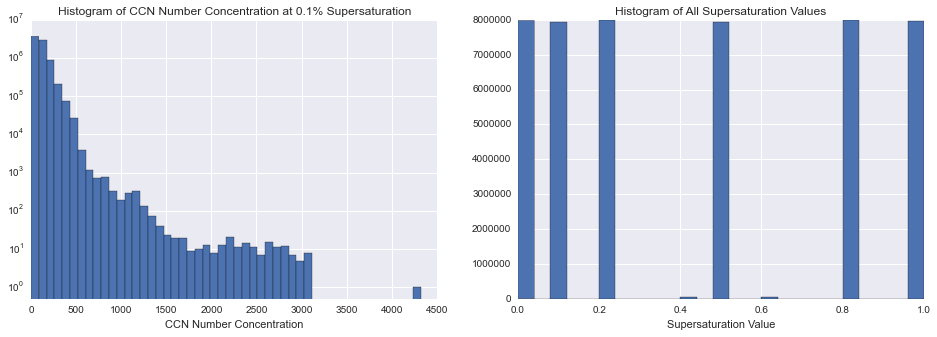

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

ccn[ss==ss_val].hist(ax=ax1, bins=50)#np.arange(0, 1000, 50))
#ax1.set_xlim(right=1000)
ax1.set_title('Histogram of CCN Number Concentration at {}% Supersaturation'.format(ss_val))
ax1.set_xlabel('CCN Number Concentration')
ax1.set_yscale('log')
ax1.set_ylim(bottom=0.5)

ss.hist(ax=ax2, bins=25)
ax2.set_xlabel('Supersaturation Value')
ax2.set_title('Histogram of All Supersaturation Values')

In [7]:
def percentile(n):
    def percentile_(x):
        return np.percentile(x, n)
    percentile_.__name__ = 'pct_%s' % n
    return percentile_

cn_tseries = (ccn[ss == ss_val]
              .groupby(pd.TimeGrouper('1W'))
              .agg([percentile(i) for i in (5, 25, 50, 75, 95)]))

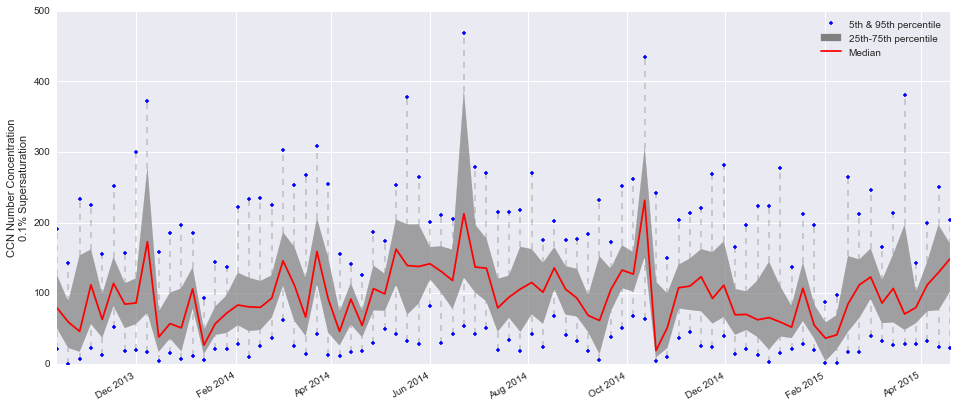

In [8]:
fig, ax = plt.subplots(figsize=(16, 7))

fly5 = ax.plot_date(cn_tseries.index, cn_tseries['pct_5'], 'b.')
fly95 = ax.plot_date(cn_tseries.index, cn_tseries['pct_95'], 'b.')

[ax.plot([i,i], [l,u], 'k--', zorder=1, linewidth=.3) 
     for i, l, u in cn_tseries[['pct_5', 'pct_25']].itertuples()]
[ax.plot([i,i], [l,u], 'k--', zorder=1, linewidth=.3) 
     for i, l, u in cn_tseries[['pct_75', 'pct_95']].itertuples()]

fl = ax.fill_between(cn_tseries.index, 
                cn_tseries['pct_25'], 
                cn_tseries['pct_75'], 
                zorder=2, alpha=0.7, color='gray', interpolate=True)

gray_patch = mpatches.Patch(color='gray')

med = ax.plot_date(cn_tseries.index, cn_tseries['pct_50'], 'r-', zorder=3)

l = ax.legend((fly95[0], gray_patch, med[0]), ('5th & 95th percentile', '25th-75th percentile','Median'))
fig.autofmt_xdate()

l = ax.set_ylabel('CCN Number Concentration\n{}% Supersaturation'.format(ss_val))